In [1]:
# imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
import spacy

# Exploratory data analysis

In [2]:
def file_to_df(path):
    with open(path, "r") as f: 
        lines = f.readlines()
        
    sentences = [" "+line.rsplit(";", 1)[0]+" " for line in lines]
    emotions = [line.rsplit(";", 1)[1][:-1] for line in lines]
        
    data_dict ={"sentence":sentences, "emotion": emotions}
    df = pd.DataFrame(data_dict)
    
    return df

In [3]:
df_train = file_to_df("../input/emotions-dataset-for-nlp/train.txt")
df_val = file_to_df("../input/emotions-dataset-for-nlp/val.txt")

df = pd.concat([df_train, df_val], ignore_index=True)

In [4]:
df

,sentence,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damne...,sadness
2,im grabbing a minute to post i feel greedy wr...,anger
3,i am ever feeling nostalgic about the firepla...,love
4,i am feeling grouchy,anger
...,...,...
17995,im having ssa examination tomorrow in the mor...,sadness
17996,i constantly worry about their fight against ...,joy
17997,i feel its important to share this info for t...,joy
17998,i truly feel that if you are passionate enoug...,joy


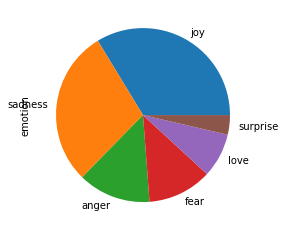

In [5]:
ax = df["emotion"].value_counts().plot(kind="pie")

# General data preprocessing for the entire dataset 
 * expand contractions 
 * fix spelling errors
 * get dummies 

In [6]:
# general preprocessing

def expand_contraction(old_string):
    rep_dict = {"didnt": "did not", "im": "i am", "ive": "i have", "hes": "he is",
                "isnt": "is not", "cant": "can not", "aint": "is not", "couldnt": "could not",
                "doesnt": "does not", "gimme":"give me", "gonna": "going to", "itll": "it will" }
    
    new_text = ""
    for i in old_string.split():
        if (i in rep_dict):
            new_text = new_text + rep_dict[i] + " "
        else:
            new_text = new_text + i + " "
    return new_text

In [7]:
df["sentence"] = df["sentence"].apply(expand_contraction)
df["sentence"] = df["sentence"].apply(lambda x: " "+ x +" ")

In [8]:
# transfering the output data to multiclass one-hot encoded outputs
df = pd.get_dummies(df, columns=["emotion"])
df.columns = df.columns.str.replace('emotion_', '')

In [9]:
df

,sentence,anger,fear,joy,love,sadness,surprise
0,i did not feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damne...,0,0,0,0,1,0
2,i am grabbing a minute to post i feel greedy ...,1,0,0,0,0,0
3,i am ever feeling nostalgic about the firepla...,0,0,0,1,0,0
4,i am feeling grouchy,1,0,0,0,0,0
...,...,...,...,...,...,...,...
17995,i am having ssa examination tomorrow in the m...,0,0,0,0,1,0
17996,i constantly worry about their fight against ...,0,0,1,0,0,0
17997,i feel its important to share this info for t...,0,0,1,0,0,0
17998,i truly feel that if you are passionate enoug...,0,0,1,0,0,0


# Creating 6 stopword sets  



In [10]:
def get_common_words(n, corpus):
    freq_map = get_frequency_map(corpus) # returns dictionary in order of most frequent to least frequent
    common_words = [list(freq_map.keys())[i] for i in range(n)]
    return common_words
    
def get_frequency_map(corpus):
    freq_map = {}

    for sentence in corpus:
        for word in sentence.split():
            if (word in freq_map):
                freq_map[word] += 1
            else:
                freq_map[word] = 1
    
    # sort the frequency map
    freq_map = {k: v for k, v in sorted(freq_map.items(), key=lambda item: item[1], reverse=True)}
    
    return freq_map

In [11]:
# returns a set of stopwords with idf value less than cutoff
def get_idf_stopwords(cutoff, corpus):
    idf_map = get_idf_map(corpus)
    idf_stopwords = [k for k, v in idf_map.items() if v < cutoff]
    return idf_stopwords
    
# returns a map of (word -> idf_value)
def get_idf_map(corpus):
    doc_freq_map = {} # word -> num docs containing word
    
    for document in corpus:
        unique_words = list(set(document.split()))
        for word in unique_words:
            if word in doc_freq_map:
                doc_freq_map[word] += 1
            else:
                doc_freq_map[word] = 1
    #print(doc_freq_map)
    
    idf_map = {}
    n_docs = len(corpus)
    #print(f'number of documents: {n_docs}')
    
    for word, doc_freq in doc_freq_map.items():
        idf_map[word] = np.log(n_docs/doc_freq)
    #print(idf_map)
    
    # sort the idf_map
    idf_map = {k: v for k, v in sorted(idf_map.items(), key=lambda item: item[1])}
    
    return idf_map

In [12]:
# nltk stopwords are already loaded as nltk_stopwords 
nltk.download("stopwords")
nltk_stopwords = stopwords.words('english')
nltk_stopwords = [word.replace("'", "") for word in nltk_stopwords] # remove ' from each word

# spacy stopwords 
en = spacy.load('en_core_web_sm')
spacy_stopwords = en.Defaults.stop_words

# 20 most common words in the dataset
top20_stopwords = get_common_words(20, df["sentence"])

# words with IDF low idf 
idf_stopwords = get_idf_stopwords(3, df["sentence"])  

# 10 most common words + nltk set
top10_stopwords_nltk = list(set(nltk_stopwords + get_common_words(10, df["sentence"])))

# last stopword set is empty set 
empty_set = []

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


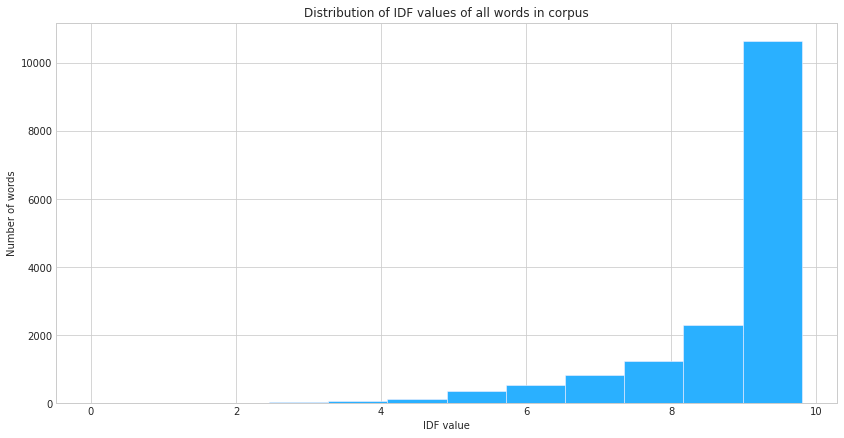

In [13]:
# Do some eda on the average idf score across all vocab 
idf_map = get_idf_map(df["sentence"])

plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(idf_map.values(), bins= 12, facecolor = '#2ab0ff', edgecolor='#fff3ff', linewidth=0.5)

plt.title('Distribution of IDF values of all words in corpus') 
plt.xlabel('IDF value') 
plt.ylabel('Number of words') 
plt.show()

# Creating 6 different preprocessed data tensors.

In [14]:
all_stopwords = [nltk_stopwords, spacy_stopwords, top20_stopwords, idf_stopwords, top10_stopwords_nltk, empty_set]
all_sentences = []
all_stopword_names = ["NTLK stopwords", "Spacy stopwords", "20 most common words", "IDF stopwords", 
                      "10 most common words + NTLK Stopwords", "Empty Set"]

for stopwords in all_stopwords:
    sentences_copy = df["sentence"].copy()
    for stopword in stopwords:
        sentences_copy = sentences_copy.apply(lambda x: x.replace(" "+stopword+" ", " "))
    all_sentences.append(sentences_copy)

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

# Load Glove Embeddings

In [16]:
# Tokenize words to find the relevant glove embeddings 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.sentence)

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

# Read GloVE embeddings
path_to_glove_file = '../input/glove-global-vectors-for-word-representation/glove.6B.200d.txt'
num_tokens = vocabSize 
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Vocabulary size = 16185
Found 400000 word vectors.
Converted 15082 words (1102 misses)


# Design a standard LSTM model and feed 6 data tensors into model. Record results 

Stopwords removed: NTLK stopwords


2022-04-29 18:22:25.719171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 18:22:25.720621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 18:22:25.721377: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 18:22:25.722291: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 200)          3237000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               336896    
_________________________________________________________________
dense (Dense)                (None, 6)                 1542      
Total params: 3,575,438
Trainable params: 338,438
Non-trainable params: 3,237,000
_________________________________________________________________
Epoch 1/5


2022-04-29 18:22:33.125982: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


57/57 [==============================] - 113s 2s/step - loss: 1.0659 - accuracy: 0.6008 - val_loss: 0.5951 - val_accuracy: 0.7969
Epoch 2/5
57/57 [==============================] - 110s 2s/step - loss: 0.4923 - accuracy: 0.8206 - val_loss: 0.3286 - val_accuracy: 0.8797
Epoch 3/5
57/57 [==============================] - 108s 2s/step - loss: 0.3076 - accuracy: 0.8853 - val_loss: 0.2505 - val_accuracy: 0.9039
Epoch 4/5
57/57 [==============================] - 108s 2s/step - loss: 0.2126 - accuracy: 0.9169 - val_loss: 0.1824 - val_accuracy: 0.9222
Epoch 5/5
57/57 [==============================] - 109s 2s/step - loss: 0.1600 - accuracy: 0.9349 - val_loss: 0.1667 - val_accuracy: 0.9281


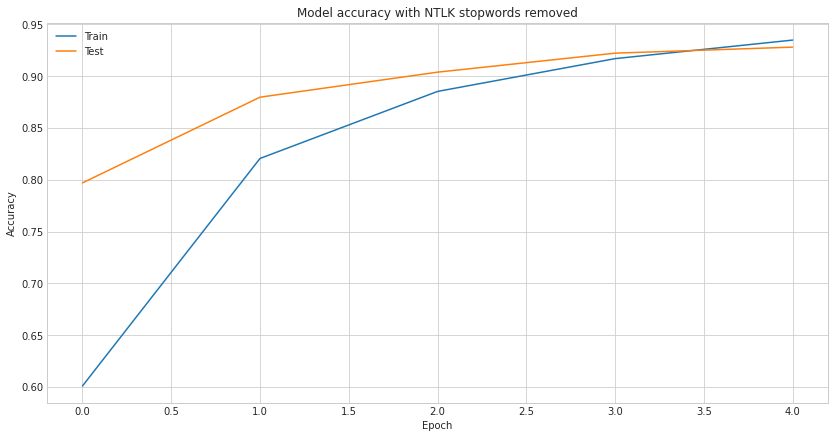

<Figure size 432x288 with 0 Axes>

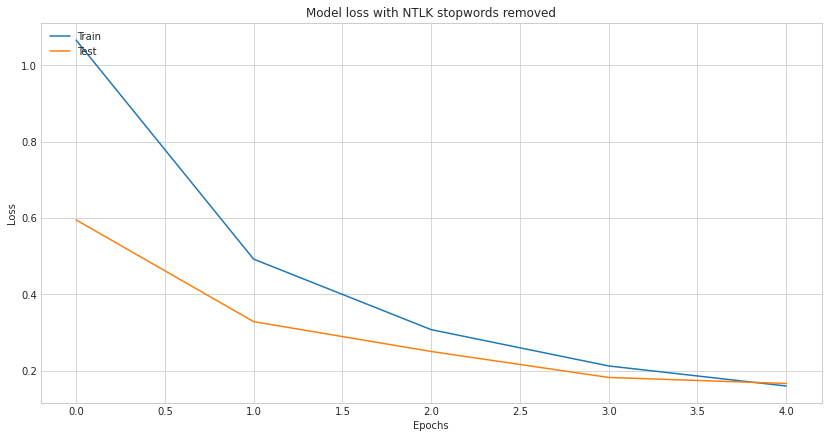

Stopwords removed: Spacy stopwords
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 200)          3237000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 3,575,438
Trainable params: 338,438
Non-trainable params: 3,237,000
_________________________________________________________________
Epoch 1/5
57/57 [==============================] - 113s 2s/step - loss: 1.0670 - accuracy: 0.6009 - val_loss: 0.6369 - val_accuracy: 0.7642
Epoch 2/5
57/57 [==============================] - 109s 2s/step - loss: 0.4964 - accuracy: 0.8201 - val_loss: 0.3355 - val_accuracy: 0.8750
Epoch 3/5
57/57 [==============================] - 10

<Figure size 432x288 with 0 Axes>

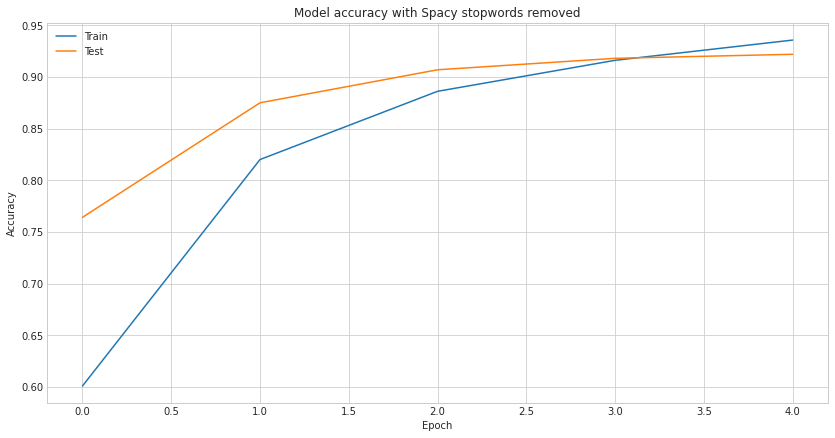

<Figure size 432x288 with 0 Axes>

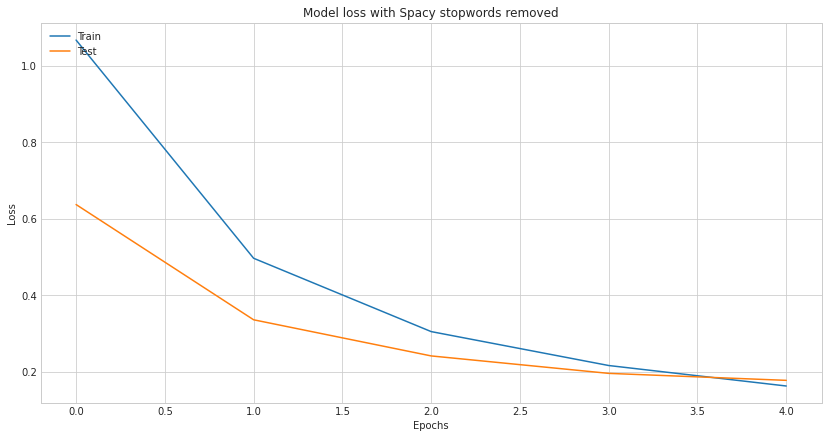

Stopwords removed: 20 most common words
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 256, 200)          3237000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 3,575,438
Trainable params: 338,438
Non-trainable params: 3,237,000
_________________________________________________________________
Epoch 1/5
57/57 [==============================] - 118s 2s/step - loss: 1.3332 - accuracy: 0.4997 - val_loss: 0.9791 - val_accuracy: 0.6389
Epoch 2/5
57/57 [==============================] - 110s 2s/step - loss: 0.7541 - accuracy: 0.7309 - val_loss: 0.5399 - val_accuracy: 0.8186
Epoch 3/5
57/57 [==============================]

<Figure size 432x288 with 0 Axes>

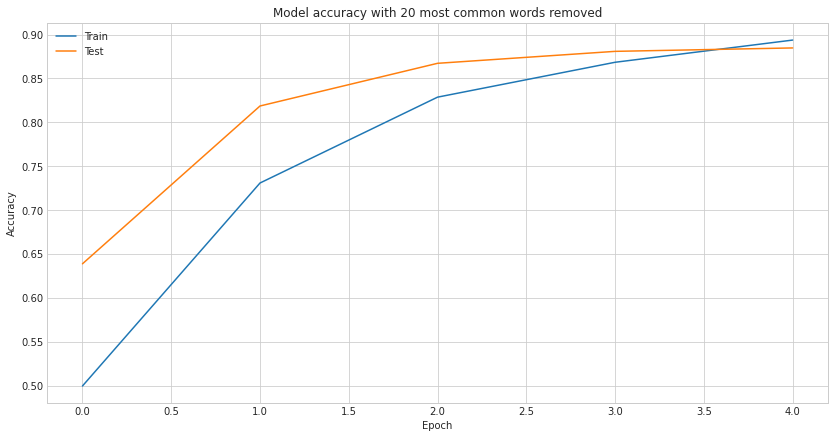

<Figure size 432x288 with 0 Axes>

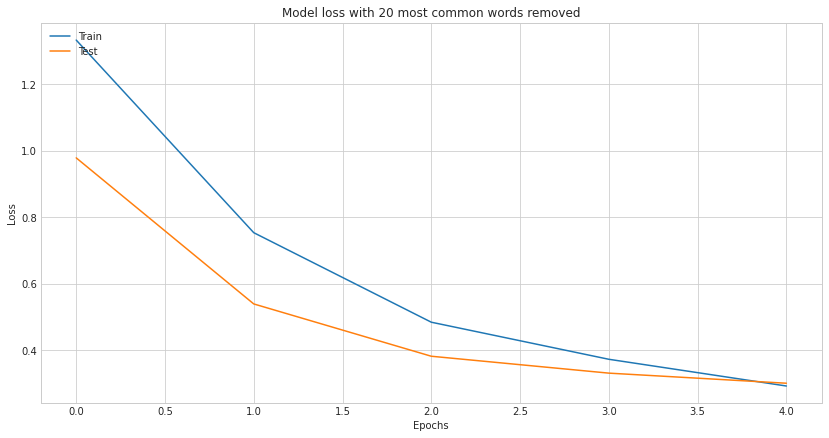

Stopwords removed: IDF stopwords
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 256, 200)          3237000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1542      
Total params: 3,575,438
Trainable params: 338,438
Non-trainable params: 3,237,000
_________________________________________________________________
Epoch 1/5
57/57 [==============================] - 113s 2s/step - loss: 1.1431 - accuracy: 0.5733 - val_loss: 0.7195 - val_accuracy: 0.7528
Epoch 2/5
57/57 [==============================] - 110s 2s/step - loss: 0.6231 - accuracy: 0.7744 - val_loss: 0.4721 - val_accuracy: 0.8364
Epoch 3/5
57/57 [==============================] - 108s

<Figure size 432x288 with 0 Axes>

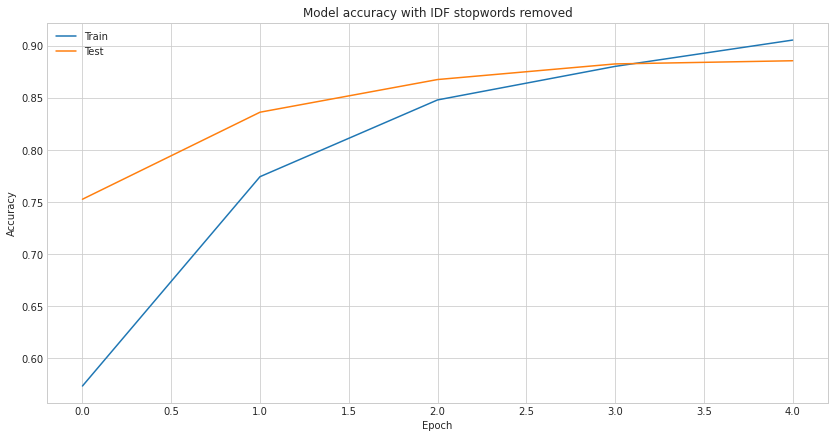

<Figure size 432x288 with 0 Axes>

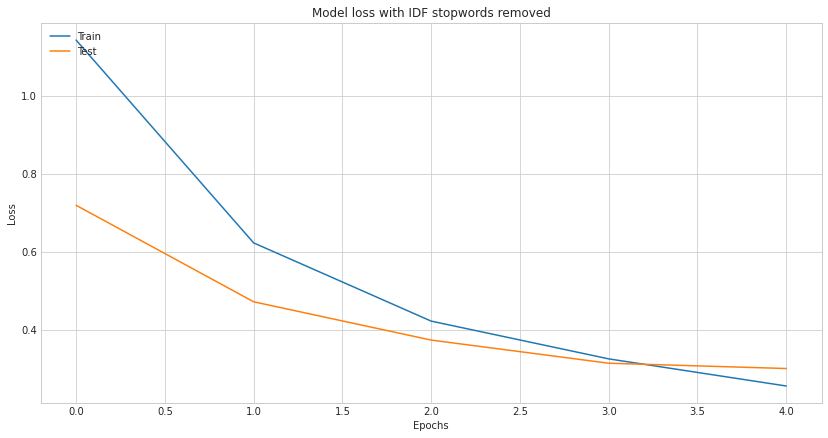

Stopwords removed: 10 most common words + NTLK Stopwords
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 256, 200)          3237000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 1542      
Total params: 3,575,438
Trainable params: 338,438
Non-trainable params: 3,237,000
_________________________________________________________________
Epoch 1/5
57/57 [==============================] - 117s 2s/step - loss: 1.1369 - accuracy: 0.5824 - val_loss: 0.7433 - val_accuracy: 0.7469
Epoch 2/5
57/57 [==============================] - 110s 2s/step - loss: 0.6077 - accuracy: 0.7856 - val_loss: 0.4768 - val_accuracy: 0.8319
Epoch 3/5
57/57 [==============

<Figure size 432x288 with 0 Axes>

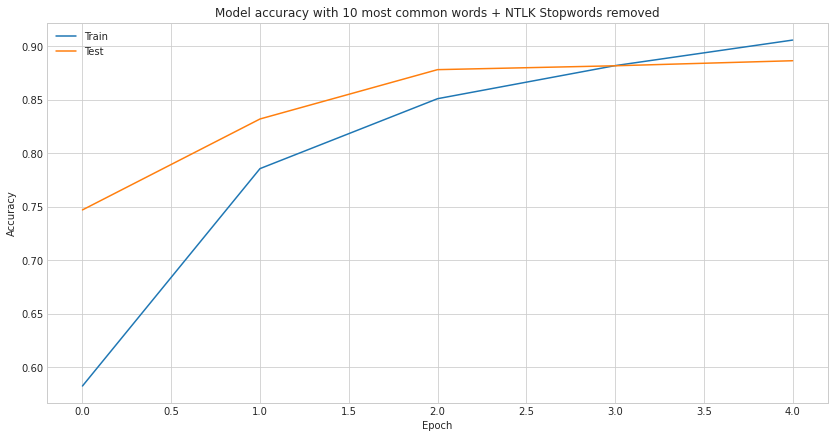

<Figure size 432x288 with 0 Axes>

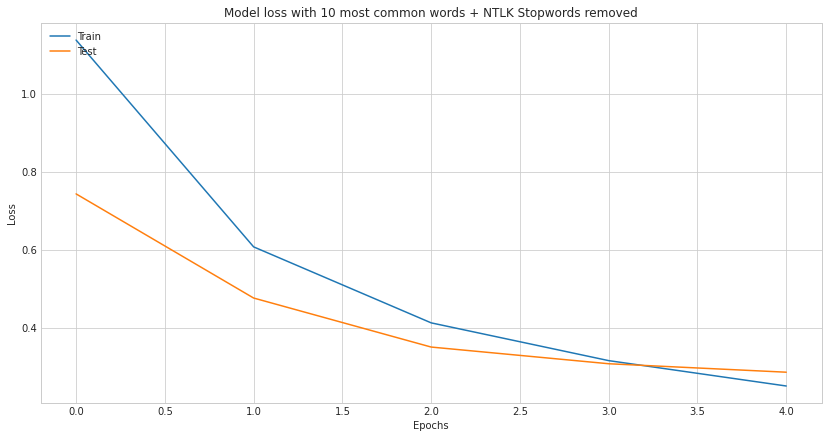

Stopwords removed: Empty Set
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 256, 200)          3237000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 1542      
Total params: 3,575,438
Trainable params: 338,438
Non-trainable params: 3,237,000
_________________________________________________________________
Epoch 1/5
57/57 [==============================] - 115s 2s/step - loss: 1.3593 - accuracy: 0.4779 - val_loss: 0.9827 - val_accuracy: 0.6436
Epoch 2/5
57/57 [==============================] - 112s 2s/step - loss: 0.6720 - accuracy: 0.7598 - val_loss: 0.4043 - val_accuracy: 0.8550
Epoch 3/5
57/57 [==============================] - 111s 2s/

<Figure size 432x288 with 0 Axes>

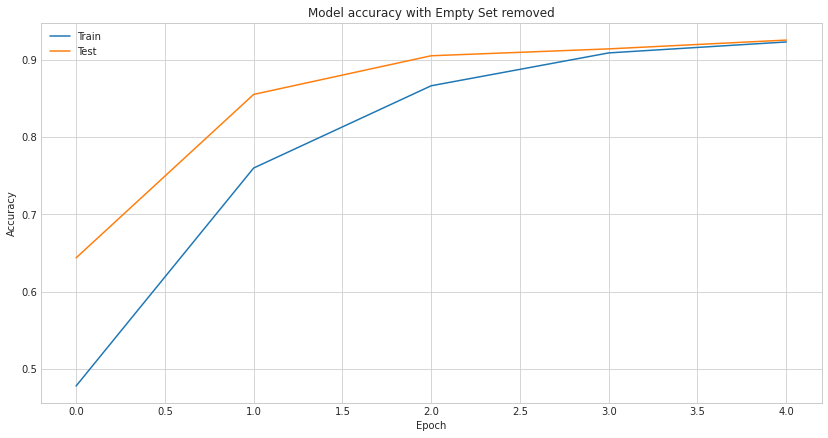

<Figure size 432x288 with 0 Axes>

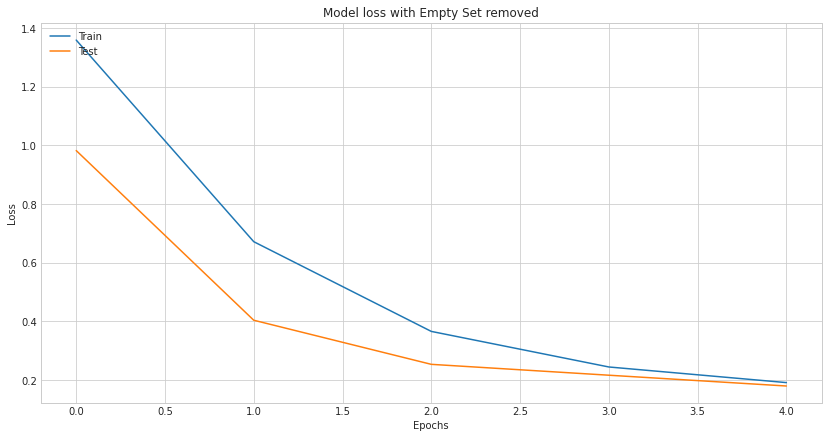

<Figure size 432x288 with 0 Axes>

In [17]:
for i, x in enumerate(all_sentences):
    print(f'Stopwords removed: {all_stopword_names[i]}')
    y = df.iloc[:, 1:]
    
#     vocabSize = len(tokenizer.index_word) + 1
#     print(f"Vocabulary size = {vocabSize}")

    sequences = tokenizer.texts_to_sequences(x)
    x = pad_sequences(sequences, maxlen=256, truncating='pre')

    # Build neural network architecture
    adam = Adam(learning_rate=0.005)
    model = Sequential()
    model.add(Embedding(vocabSize, 200, input_length=x.shape[1], weights=[embedding_matrix], trainable=False))
    model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.summary()
    callback = EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True,
    )

    # Fit model
    history = model.fit(x, y, validation_split = 0.2, verbose=1,batch_size=256, epochs=5, callbacks=[callback])
    
    # summarize history for accuracy
    plt.figure(figsize=(14,7)) # Make it 14x7 inch
    plt.style.use('seaborn-whitegrid') # nice and clean grid
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy with '+ all_stopword_names[i] + " removed")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    plt.savefig(all_stopword_names[i] + '_acc.png')
    
    # summarize history for loss
    plt.figure(figsize=(14,7)) # Make it 14x7 inch
    plt.style.use('seaborn-whitegrid') # nice and clean grid
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss with '+ all_stopword_names[i] + " removed")
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    plt.savefig(all_stopword_names[i] + '_loss.png')